# Individuel

In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Connect to DuckDB 
con = duckdb.connect("football.duckdb")

# Sécurité mémoire
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA memory_limit='4GB';")

print("DuckDB ready")

con.execute("""
CREATE OR REPLACE TABLE summary AS
SELECT *
FROM read_csv_auto('data/summary.csv')
""")

DuckDB ready


## Tableau de zone

In [20]:
player_pseudo = 1      
month = '2020-03'            # format YYYY-MM
def speed_zone(player, date):
    df_speed = con.execute(f"""
    SELECT
        strftime('%Y-%m', session_date) AS month,
        player_pseudo,
        MAX(speed_kmh) AS max_speed_kmh
    FROM tracking_games
    WHERE player_pseudo = '{player_pseudo}'
    AND strftime('%Y-%m', session_date) = '{month}'
    GROUP BY month, player_pseudo
    """).df()
    zones = [0,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [
        '0-40%',
        '40-50%',
        '50-60%',
        '60-70%',
        '70-80%',
        '80-90%',
        '90-100%'
    ]
    vmax = df_speed['max_speed_kmh'].values[0]

    df_zone = pd.DataFrame({
        'zone': labels,
        'min_speed_kmh': [vmax * z1 for z1 in zones[:-1]],
        'max_speed_kmh': [vmax * z2 for z2 in zones[1:]],
    })
    return df_zone
speed_zone(player_pseudo, month)


,zone,min_speed_kmh,max_speed_kmh
0,0-40%,0.000000,11.396304
1,40-50%,11.396304,14.245380
2,50-60%,14.245380,17.094456
3,60-70%,17.094456,19.943532
4,70-80%,19.943532,22.792608
5,80-90%,22.792608,25.641684
6,90-100%,25.641684,28.490760


## Profile accélération vitesse

Pour tracer le profil, il est proposé, à partir d’une vitesse de 3 m/s, de prendre toutes les 0,2 m/s les deux points dont l’accélération est maximale puis de calculer la droite de régression de l’accélération par rapport à la vitesse.
Miguens et al. [6] proposent une régression quantile dans le cadre du rugby.

C:\Users\theol\AppData\Local\Temp\ipykernel_3608\1690955278.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('speed_bin')


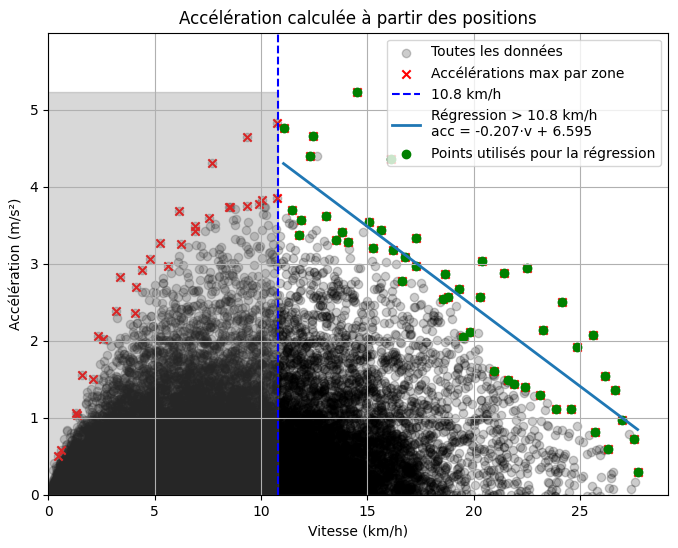

In [ ]:
player = 41
match = '2020-02-01'
fs = 10  # Hz
dt = 1 / fs

df = con.execute(f"""
SELECT *
FROM tracking_games
WHERE session_date = '{match}'
AND player_pseudo = {player}
ORDER BY session_date
""").df()
# Calcul de l'accélération
df['speed_ms'] = df['speed_kmh'] / 3.6
df['acceleration'] = df['speed_ms'].diff() / dt

#A partir de 10.8 km/h puis + 0.72 km/h choisir les deux points dont l'accélération est maximale
#Tracer sur plt accélération en fonction de la vitesse
v_start = 0
step = 0.72
df = df[df['speed_kmh'] >= v_start].copy()

# Création des bornes
v_max = df['speed_kmh'].max()
bins = np.arange(v_start, v_max + step, step)

df['speed_bin'] = pd.cut(
    df['speed_kmh'],
    bins=bins,
    include_lowest=True
)
df_max_acc = (
    df
    .sort_values('acceleration', ascending=False)
    .groupby('speed_bin')
    .head(2)
    .dropna(subset=['speed_bin'])
)

# Seuil
v_threshold = 10.8

df_reg = df_max_acc[
    df_max_acc['speed_kmh'] >= v_threshold
].copy()
df_reg = df_reg.dropna(subset=['speed_kmh', 'acceleration'])


# Régression linéaire
coef = np.polyfit(
    df_reg['speed_kmh'],
    df_reg['acceleration'],
    1
)

a, b = coef  # pente et intercept

v_line = np.linspace(
    df_reg['speed_kmh'].min(),
    df_reg['speed_kmh'].max(),
    100
)

acc_line = a * v_line + b





# Tracé
plt.figure(figsize=(8, 6))

plt.scatter(
    df['speed_kmh'],
    df['acceleration'],
    alpha=0.2,
    color='black',
    label='Toutes les données'
)

plt.scatter(
    df_max_acc['speed_kmh'],
    df_max_acc['acceleration'],
    marker='x',
    color='red',
    label='Accélérations max par zone'
)

#Ajout  ligne verticale à 10.8 km/h
plt.axvline(x=10.8, color='blue', linestyle='--', label='10.8 km/h')
#Mettre en gris les parties avant 10.8 km/h
plt.fill_betweenx(
    y=[df['acceleration'].min(), df['acceleration'].max()],
    x1=-1,
    x2=10.8,
    color='gray',
    alpha=0.3
)

#Droite de régression
plt.plot(
    v_line,
    acc_line,
    linestyle='-',
    linewidth=2,
    label=f"Régression > 10.8 km/h\nacc = {a:.3f}·v + {b:.3f}"
)
#Mettre en Vert les points utilisés pour la régression
plt.scatter(
    df_reg['speed_kmh'],
    df_reg['acceleration'],
    marker='o',
    color='green',
    label='Points utilisés pour la régression'
)

plt.xlabel('Vitesse (km/h)')
plt.xlim(0)
plt.ylabel('Accélération (m/s²)')
plt.ylim(0)
plt.title('Accélération calculée à partir des positions')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\theol\OneDrive\Bureau\Théo\staps\Master\IEAP\Projet transversal\Data-Science-Foot\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


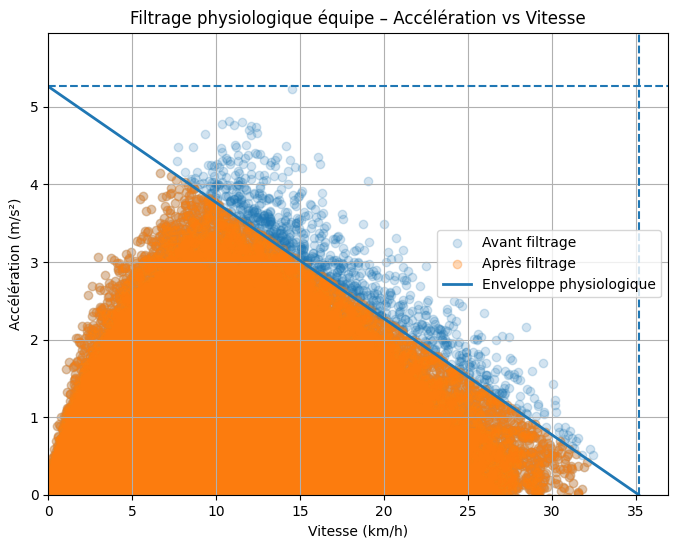

μV = 29.19 km/h | σV = 2.00 → V_lim = 35.17
μA = 4.72 m/s² | σA = 0.18 → A_lim = 5.26
Points supprimés : 828 / 581133


In [34]:
match = '2020-02-01'

#Norme Physiologique equipe vitesse et accélération
df_all = con.execute(f"""
SELECT
    player_pseudo,
    session_date,
    speed_kmh
FROM tracking_games
WHERE session_date = '{match}'
ORDER BY player_pseudo, session_date
""").df()

df_all['speed_ms'] = df_all['speed_kmh'] / 3.6

df_all['acceleration'] = (
    df_all
    .groupby('player_pseudo')['speed_ms']
    .diff()
    / dt
)
df_all = df_all.dropna(subset=['acceleration'])

df_all = df_all[
    (df_all['speed_kmh'] >= 0) &
    (df_all['speed_kmh'] <= 40) &        # plafond large
    (df_all['acceleration'].abs() <= 10) # m/s²
]

df_Vmax = (
    df_all
    .groupby('player_pseudo')['speed_kmh']
    .max()
    .reset_index(name='vmax')
)

mu_V = df_Vmax['vmax'].mean()
sigma_V = df_Vmax['vmax'].std()

V_lim = mu_V + 3 * sigma_V

df_Apos = df_all[df_all['acceleration'] > 4.5]

mu_A = df_Apos['acceleration'].mean()
sigma_A = df_Apos['acceleration'].std()

A_lim = mu_A + 3 * sigma_A

def is_physio_valid(speed, accel, V_lim, A_lim):
    return accel <= A_lim * (1 - speed / V_lim)

df_physio = df_all[
    (df_all['speed_kmh'] <= V_lim) &
    (df_all['acceleration'] <= A_lim) &
    (df_all.apply(
        lambda r: is_physio_valid(
            r['speed_kmh'],
            r['acceleration'],
            V_lim,
            A_lim
        ),
        axis=1
    ))
].copy()

v_line = np.linspace(0, V_lim, 200)
a_line = A_lim * (1 - v_line / V_lim)

plt.figure(figsize=(8, 6))

plt.scatter(
    df_all['speed_kmh'],
    df_all['acceleration'],
    alpha=0.2,
    label='Avant filtrage'
)

plt.scatter(
    df_physio['speed_kmh'],
    df_physio['acceleration'],
    alpha=0.3,
    label='Après filtrage'
)

plt.plot(v_line, a_line, linewidth=2, label='Enveloppe physiologique')

plt.axvline(V_lim, linestyle='--')
plt.axhline(A_lim, linestyle='--')

plt.xlabel('Vitesse (km/h)')
plt.ylabel('Accélération (m/s²)')
plt.xlim(0)
plt.ylim(0)
plt.title('Filtrage physiologique équipe – Accélération vs Vitesse')
plt.legend()
plt.grid(True)
plt.show()

print(f"μV = {mu_V:.2f} km/h | σV = {sigma_V:.2f} → V_lim = {V_lim:.2f}")
print(f"μA = {mu_A:.2f} m/s² | σA = {sigma_A:.2f} → A_lim = {A_lim:.2f}")
print(f"Points supprimés : {len(df_all) - len(df_physio)} / {len(df_all)}")

